In [4]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [7]:
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [8]:
Base = automap_base()
Base.prepare(engine, reflect=True)

In [9]:
print(Base.classes.keys())

['measurement', 'station']


In [10]:
station = Base.classes.station
measurement = Base.classes.measurement

In [11]:
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
last_row = session.query(measurement.date).order_by(measurement.date.desc()).first()
last_row

('2017-08-23',)

In [13]:
last_date_string = last_row[0]
last_date_string

'2017-08-23'

In [14]:
last_date = dt.date.fromisoformat(last_date_string)

<AxesSubplot:xlabel='Date', ylabel='Inches'>

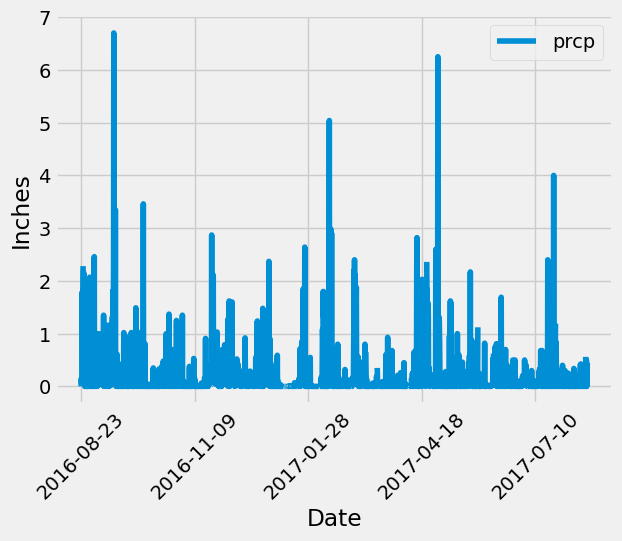

In [15]:
year_prior = last_date - dt.timedelta(days=365)

prcp_data = session.query(measurement.date, measurement.prcp)\
    .filter(measurement.date >= year_prior)\
    .order_by(measurement.date)\
    .all()

prcp_df = pd.DataFrame(prcp_data).set_index("date").sort_index()
prcp_df

prcp_df.plot(rot=45, xlabel="Date", ylabel="Inches")


In [16]:
prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
session.query(station.station).count()

9

In [18]:
station_query = sqlalchemy.select([
    measurement.station, 
    sqlalchemy.func.count(measurement.station)
    ]).group_by(measurement.station).order_by(func.count(measurement.station).desc())

result = engine.execute(station_query).fetchall()

for i in result:
    print("\n", i)


 ('USC00519281', 2772)

 ('USC00519397', 2724)

 ('USC00513117', 2709)

 ('USC00519523', 2669)

 ('USC00516128', 2612)

 ('USC00514830', 2202)

 ('USC00511918', 1979)

 ('USC00517948', 1372)

 ('USC00518838', 511)


In [39]:
most_active = result[0][0]

most_active_stats = session.query(func.min(measurement.tobs), 
    func.max(measurement.tobs), func.avg(measurement.tobs)).\
        filter(measurement.station == most_active).all()

print(most_active_stats)

[(54.0, 85.0, 71.66378066378067)]


In [56]:
year_stats = session.query(measurement.date, measurement.tobs).\
    filter(measurement.date >= year_prior).\
    filter(measurement.station == most_active).all()

year_stats_df = pd.DataFrame(year_stats).set_index("date").sort_index()
year_stats_df

,tobs
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


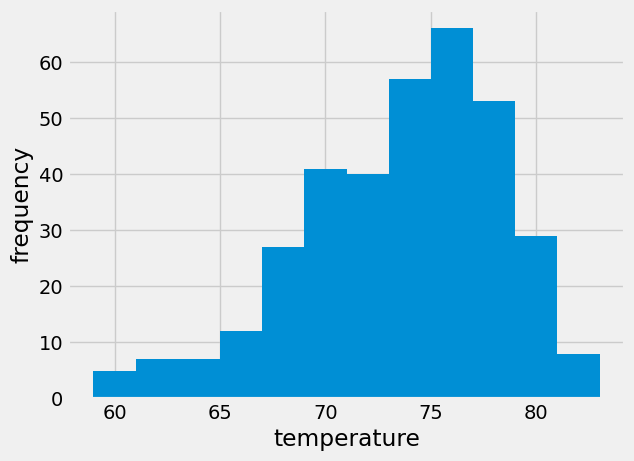

In [58]:
histogram_bins = year_stats_df["tobs"]
histogram_bins.hist(bins=12)
plt.xlabel("temperature")
plt.ylabel("frequency")
plt.show()

# Close session

In [59]:
session.close()